# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
import pickle
import datasets as dst

import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix


# Chargement des données et prétraitement

In [2]:
def preProcessDataframe(df: object) -> object:
    dfret = df.dropna(subset = [
        "station_id", 
        "lat", 
        "lon", 
        "occupation_prct", 
        "occupation_class"
    ]).copy()
    
    dfret['jour'] = dfret["time"].dt.day
    dfret['heure'] = dfret["time"].dt.hour
    dfret['minute'] = dfret["time"].dt.minute
    
    return dfret

In [3]:


df0 = dst.getDataset("2023_03_17", path)
df1 = dst.getDataset("2023_03_18", path)
df2 = dst.getDataset("2023_03_19", path)
df3 = dst.getDataset("2023_03_20", path)
df4 = dst.getDataset("2023_03_21", path)
df5 = dst.getDataset("2023_03_22", path)

#Je réduis systématiquement la résolution en temps par 10 sur ce classeur
step=10
df0=df0.iloc[0::step]
df1=df1.iloc[0::step]
df2=df2.iloc[0::step]
df3=df3.iloc[0::step]
df4=df4.iloc[0::step]
df5=df5.iloc[0::step]


df0=preProcessDataframe(df0)
df1=preProcessDataframe(df1)
df2=preProcessDataframe(df2)
df3=preProcessDataframe(df3)
df4=preProcessDataframe(df4)
df5=preProcessDataframe(df5)

In [4]:
#On vérifie que prendre une ligne sur 10 laisse un meme nombre de points par station
df=df1
station_list=list(set(df.station_id))
Nst=len(station_list)
Nt=len(set(df[df['station_id'] == station_list[0]].time))
station_timeserie=np.ndarray([Nst,Nt])

foo=[]
for i in station_list : 
    foo.append(len(set(df[df['station_id'] == i]) ))
print(np.min(foo) , np.max(foo) )

22 22


In [5]:
## Ajout de valeurs d'occupation 6h plus tot :
def add_old_values(df, df_old=None):
    dec1=6*3 #on a une valeur toutes les 20 minutes, et on regarde 6 heures avant
    dec2=6*3+24*3 #on a une valeur toutes les 20 minutes, et on regarde 6+24 heures avant
    
    if df_old is None:
        df_main=df.copy()
    else : 
        df_main=pd.concat([df_old, df])
        
    df_main["occupation_diff"]=df_main["occupation_prct"].shift(periods=dec1, axis=0)-df_main["occupation_prct"].shift(periods=dec2, axis=0)

   
    df_main=df_main[df_main['jour'] == df['jour'].median()]
    
    
    return df_main


In [7]:
df5=add_old_values(df5, df4)
df4=add_old_values(df4, df3)
df3=add_old_values(df3, df2)
df2=add_old_values(df2, df1)
df1=add_old_values(df1, df0)
df0=add_old_values(df0)
# df0=df0.dropna(subset=['old_occupation_prct','old_occupation_class'])

## Entrainement et prédiction

### Une station à la fois

In [11]:
df_tot=pd.concat([df0,df1])
df_tot=pd.concat([df_tot,df2])
df_tot=pd.concat([df_tot,df3])
df_tot=pd.concat([df_tot,df4])
df_tot=pd.concat([df_tot,df5])

df_tot=df_tot.dropna(subset=["occupation_diff"])

df_train=df_tot[df_tot["jour"] == 22]
df_test=df_tot[df_tot["jour"] == 21]


In [51]:
def test_one_regr(df_train_in: object, df_test_in, feat_supp=[], station=None) -> None:
    
    if station is None :
        station=random.sample(station_list,1)[0]
    print(station)
    
    
    df_train=df_train_in[df_train_in['station_id'] == station]
    df_test=df_test_in[df_test_in['station_id'] == station]

    feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
    feat2 = feat1+["occupation_diff","occupation_diff"]
    target = ["occupation_prct"]

    x_train1=df_train[feat1]
    x_train2=df_train[feat2]
    y_train=df_train[target]

    x_test1=df_test[feat1]
    x_test2=df_test[feat2]
    y_test=df_test[target]

    clf1 = GradientBoostingRegressor(random_state=0)
    clf1.fit(x_train1, y_train.values.ravel())

    clf2 = GradientBoostingRegressor(random_state=0)
    clf2.fit(x_train2, y_train.values.ravel())


    y_pred1 = clf1.predict(x_test1)
    y_pred2 = clf2.predict(x_test2)

    x=df_test['time']
    
    print(x.shape, y_test.shape, y_pred1.shape)
    
    plt.figure(figsize=(16,6))
    plt.plot(x, y_test.values.ravel(), color='black', label='True')
    plt.plot(x, y_pred1, color='red', label='Pred. basic')
    plt.plot(x, y_pred2, color='blue', label='Pred. basic+old values')
    
    plt.plot(x, y_train.values.ravel(), color='green', label='Veille')
    
    plt.legend()
    plt.show()

    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': clf1.feature_names_in_,
        'importance': clf1.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
#     print('feature', clf1.feature_names_in_,)
#     print(clf1.coef_)
    
    #plot variable importances of the model
    plt.title('Variable Importances : basic prediction', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': clf2.feature_names_in_,
        'importance': clf2.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances ; basic + old values', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()
    
    
#     print(dir(clf1))
# test_one(df_train, df_test)

597245295
(71,) (71, 1) (71,)


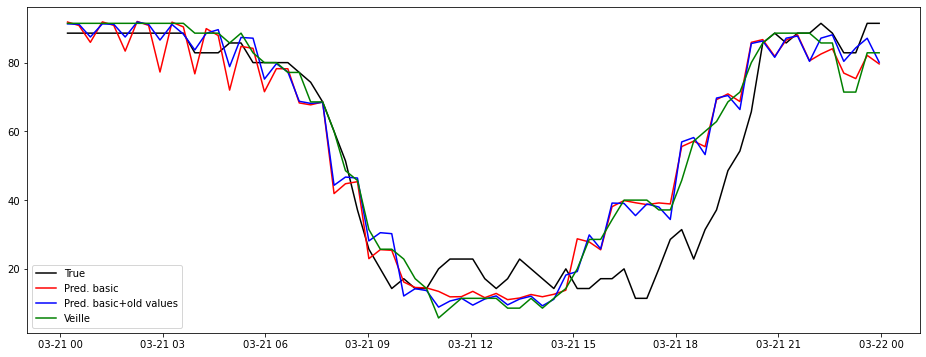

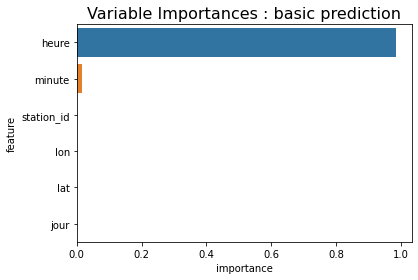

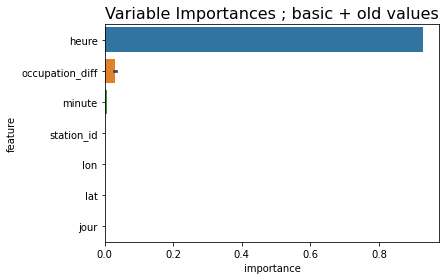

In [53]:
# 129021753
# 129083553
test_one_regr(df_train, df_test)

In [39]:
    feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
    feat2 = feat1+["occupation_diff"]
    target = ["occupation_prct"]

    x_train1=df_train[feat1]
    x_train2=df_train[feat2]
    y_train=df_train[target]

    x_test1=df_test[feat1]
    x_test2=df_test[feat2]
    y_test=df_test[target]

    clf1 = GradientBoostingRegressor(random_state=0)
    clf1.fit(x_train1, y_train.values.ravel())


GradientBoostingRegressor(random_state=0)

In [45]:
clf1.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x1DF987D1A40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x1DF987D1A40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x1DF987D1A40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x1DF987D1A40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x1DF987D1A40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x1DF987D1A40)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
             

In [42]:
dir(clf1)


['_SUPPORTED_LOSS',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_initialized',
 '_check_n_features',
 '_check_params',
 '_clear_state',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_fit_stage',
 '_fit_stages',
 '_get_param_names',
 '_get_tags',
 '_init_state',
 '_is_initialized',
 '_make_estimator',
 '_more_tags',
 '_raw_predict',
 '_raw_predict_init',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_resize_state',
 '_rng',
 '_staged_raw_predict',

In [91]:
feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
feat2 = feat1+["occupation_diff"]
target = ["occupation_class"]

x_train1=df_train[feat1]
x_train2=df_train[feat2]
y_train=df_train[target]

x_test1=df_test[feat1]
x_test2=df_test[feat2]
y_test=df_test[target]

In [93]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf1.fit(x_train1, y_train.values.ravel())

clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf2.fit(x_train2, y_train.values.ravel())


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [94]:
y_pred1 = clf1.predict(x_test1)
y_pred2 = clf2.predict(x_test2)


In [95]:
accuracy_score(y_test, y_pred1)

0.4228224809092872

In [96]:
accuracy_score(y_test, y_pred2)

0.4221943032135215

In [220]:
def test_one_class(df_train_in: object, df_test_in, feat_supp=[]) -> None:
    
    station=random.sample(station_list,1)[0]
    print(station)
    
    
    df_train=df_train_in[df_train_in['station_id'] == station]
    df_test=df_test_in[df_test_in['station_id'] == station]

    feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
    feat2 = feat1+["occupation_diff"]
    target = ["occupation_class"]

    x_train1=df_train[feat1]
    x_train2=df_train[feat2]
    y_train=df_train[target]

    x_test1=df_test[feat1]
    x_test2=df_test[feat2]
    y_test=df_test[target]

    clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    clf1.fit(x_train1, y_train.values.ravel())

    clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    clf2.fit(x_train2, y_train.values.ravel())


    y_pred1 = clf1.predict(x_test1)
    y_pred2 = clf2.predict(x_test2)


#     print(feat)
#     print(clf.feature_importances_)

#     cm1 = confusion_matrix(y_test, y_pred1)
    
    
#     cm2 = confusion_matrix(y_test, y_pred2)

#     sns.heatmap(cm1, annot=True, cmap="Blues", fmt="g")
#     sns.heatmap(cm2, annot=True, cmap="Blues", fmt="g")    
    
#     plt.xlabel('Prédictions')
#     plt.ylabel('Valeurs réelles')
#     plt.show()
    
#     print(classification_report(y_test,y_pred1))
#     print(classification_report(y_test,y_pred2))


#     print(len(y_test),len(y_pred1),len(y_pred2))
#     print(type(y_test),len(y_pred1),len(y_pred2))

    plt.plot(y_test.values.ravel(), color='black', label='True')
    plt.plot(y_pred1, color='red', label='Pred. basic')
    plt.plot(y_pred2, color='blue', label='Pred. basic+old values')
    plt.legend()
    plt.show()

#     print(y_test.values.ravel())
#     print('\n')
#     print(y_pred1)
#     print('\n')
#     print(y_pred2)

# test_one(df_train, df_test)

82445192


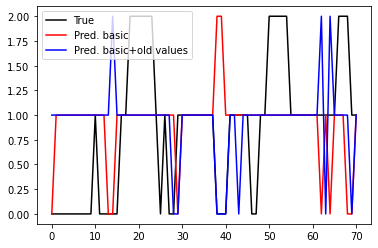

In [221]:
test_one_class(df_train, df_test)